In [1]:
import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tyro
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import copy

In [2]:
@dataclass
class Args:
    exp_name: str = 'ppo'
    """the name of this experiment"""
    seed: int = 12
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm simulation arguments
    env_id: str = "CartPole-v1"
    """the id of the environment"""
    total_timesteps: int = 5000
    """total timesteps of the experiments"""
    num_envs: int = 4
    """the number of parallel game environments"""
    num_steps: int = 64
    """the number of steps to run in each environment per policy rollout"""
    gamma: float = 0.99
    """the discount factor gamma"""

    #Frequency simulation arguments
    M: int = 10
    """ the number of frequency samples is M"""
    sigmaOmega: float = 3
    """ the standard deviation of the normal distribution from which the frequency is sampled """
    
    # traing arguments for critic
    batch_size: int = 16
    """batch_size for critic training"""
    epochs: int = 4
    """number of epochs for critic training"""
    learning_rate: float = 0.001
    """learning for critic training"""
    lw: float = 0.0
    """L2 regularization coefficient for critic training"""
    
    #to be filled at runtime
    num_iterations: int = 0
    """the number of iterations (computed in runtime)"""
    data_size_critic: int = 0
    """the number of dataset points over which critic is trained on (per iteration)"""
    critic_state_size: int = 0
    """the number of states over which critic is trained on (per iteration)"""

In [3]:
args = Args()
args.critic_state_size = int(args.num_envs * args.num_steps)
args.num_iterations = args.total_timesteps // args.critic_state_size

run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )
print(args.num_iterations)

19


In [4]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

In [5]:
def make_env(env_id, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env

    return thunk

In [6]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    
    return layer

class xsinx(nn.Module):
    def __init__(self, a=1.0):
        super(xsinx, self).__init__()
        self.a = nn.Parameter(torch.tensor(a))

    def forward(self, x):
        return x + (1.0 / self.a) * torch.sin(self.a * x) ** 2

In [7]:
class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )

    def get_action(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action

In [8]:
class cf(torch.nn.Module):
    def __init__(self, state_input_size, layer_sizes, sigma, sigma_opt=False):
        super().__init__()
        # Output size is twice the complex output size to account for real and imaginary parts
        output_size = 2
        self.layer_sizes = [state_input_size + 1] + layer_sizes + [output_size]
        self.layers = torch.nn.ModuleList()

        for i in range(len(self.layer_sizes) - 2):
            self.layers.append(layer_init(torch.nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1])))
            self.layers.append(xsinx(a=0.5))
        
        self.layers.append(layer_init(torch.nn.Linear(self.layer_sizes[-2], self.layer_sizes[-1])))

        if sigma_opt:
            self.sigma = torch.nn.Parameter(sigma)
        else:
            self.sigma = sigma

    def freq_sampling(self, num_samples):

        std_sample = torch.distributions.Normal(0.0, 1.0).sample((num_samples,)).to(device)
        return self.sigma * std_sample

    def forward(self,x):

        if x.dim() == 1:
            x = x.unsqueeze(0)

        for i, layer in enumerate(self.layers):
            x = layer(x)

        out = torch.zeros_like(x)
        out[:, 0] = torch.cos(x[:, 0])
        out[:, 1] = torch.sin(x[:, 1])        

        # Split the output into real and imaginary parts and form the complex output
        real = out[:,0]
        imag = out[:,1]
        return torch.complex(real, imag)

    def get_mean(self,state):
        omega_fixed = torch.tensor([0.0], requires_grad=True).expand(state.size(0)).unsqueeze(1).to(device)
        eva = torch.cat((state,omega_fixed),dim=1)
        output = self.forward(eva).imag
        gradients = torch.autograd.grad(outputs=output, inputs=eva, grad_outputs=torch.ones_like(output),allow_unused=True)
        return gradients[0][:,-1]

In [9]:
cf_network = cf(4, [64, 64,64], 0.1,sigma_opt=False).to(device)
model_optimizer = optim.Adam(cf_network.parameters(), weight_decay = args.lw)

In [10]:
envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, i, args.capture_video, run_name) for i in range(args.num_envs)],
    )
agent = Agent(envs).to(device)

In [11]:
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)

input_data = torch.zeros((args.num_steps, args.num_envs*args.M)+envs.single_observation_space.shape).to(device)
output_data = torch.zeros((args.num_steps,args.num_envs*args.M),dtype=torch.complex128)

In [12]:
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=args.seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(args.num_envs).to(device) 

In [13]:
def ecf(samples,omega):
    expo_samples = torch.exp(1j*omega*samples)  

    return expo_samples
    
vectorized_ecf = torch.vmap(ecf,in_dims=(0,None),chunk_size=10)

def td_update(r, t, ns, model,ndone):
    t_expanded = t.unsqueeze(0).expand(r.size(0), -1)
    input_tensor = torch.cat((ns, args.gamma*t_expanded), dim=-1)
    with torch.no_grad():
        return (1.0-ndone)*torch.exp(1j*t*r).flatten() + ndone*model(input_tensor).flatten()*torch.exp(1j*t*r).flatten()

# Function to apply td_update for a single t value
def single_td(r, ns, t, model,ndone):
    return td_update(r, t, ns, model,ndone)

# Vectorize over t values using vmap
def vectorized_td(r, ns, t_list, model,ndone):
    return torch.vmap(lambda t: single_td(r, ns, t, model,ndone), in_dims=0, out_dims=0)(t_list)

In [14]:
model_copies = []
for iteration in range(1, args.num_iterations + 1):

    std_sample = torch.randn(args.M).to(device)
    omega = (args.sigmaOmega * std_sample).to(device)
    #omega = torch.cat((omega, (torch.zeros(3*args.M)).to(device)), dim=0).to(device)
    
    for step in range(0, args.num_steps):
        
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action = agent.get_action(next_obs)
        actions[step] = action
    
        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = 0.25*torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                    writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    with torch.no_grad():
        returns = torch.zeros_like(rewards).to(device)
        last = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                output_data[t] = vectorized_td(rewards[t], next_obs, omega, cf_network,nextnonterminal).transpose(0,1).flatten()
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                output_data[t] = vectorized_td(rewards[t], obs[t+1], omega, cf_network,nextnonterminal).transpose(0,1).flatten()

            delta = rewards[t]
            returns[t] = last = delta + args.gamma*nextnonterminal * last
            input_data[t] = obs[t].repeat_interleave(omega.shape[0], dim=0).to(device)
            
        
        
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_returns = returns.reshape(-1)

    # Organize the input data with the collected frequency samples:

    state_repeated = input_data.reshape((-1,) + envs.single_observation_space.shape)
    omega_repeated = omega.repeat(b_obs.shape[0]).to(device)
    state_omega = torch.cat((state_repeated, omega_repeated.unsqueeze(1)), dim=1)

    # Organize the target data with the collected frequency samples:

    ecfSamples = output_data.reshape(-1)
    args.data_size_critic = state_omega.shape[0]
    num_batches = args.data_size_critic//args.batch_size 

    lossEpoch = np.zeros(args.epochs)
    b_inds = np.arange(args.data_size_critic)

    for epoch in range(args.epochs):
        np.random.shuffle(b_inds)
    
        frac = 1.0 - epoch/ args.epochs
        lrnow = frac * args.learning_rate
        model_optimizer.param_groups[0]["lr"] = lrnow

        for i in range(num_batches):

            start_idx = i * args.batch_size
            end_idx = start_idx + args.batch_size

            mb_inds = b_inds[start_idx:end_idx]
            
            inputs = state_omega[mb_inds]
            targets = ecfSamples[mb_inds]

            model_optimizer.zero_grad()  # Zero the gradients for the model parameters

            outputs = cf_network(inputs)

            loss_cfNN = torch.mean(torch.abs(outputs - targets)**2) 
            loss_cfNN.backward()
            model_optimizer.step()
    
            lossEpoch[epoch]+=loss_cfNN.item()

        print(f'Epoch {epoch+1}, Loss: {lossEpoch[epoch]}')
    
    model_copies.append(copy.deepcopy(cf_network.state_dict()))
    print(f'Iteration {iteration}')

global_step=48, episodic_return=[12.]
global_step=56, episodic_return=[14.]
global_step=80, episodic_return=[20.]
global_step=92, episodic_return=[11.]
global_step=128, episodic_return=[32.]
global_step=140, episodic_return=[21.]
global_step=148, episodic_return=[17.]
global_step=148, episodic_return=[14.]
global_step=176, episodic_return=[12.]
global_step=228, episodic_return=[22.]
global_step=248, episodic_return=[25.]
Epoch 1, Loss: 44.85610200844709
Epoch 2, Loss: 29.008151663329347
Epoch 3, Loss: 23.81820596608727
Epoch 4, Loss: 22.258434341448883
Iteration 1
global_step=280, episodic_return=[13.]
global_step=332, episodic_return=[46.]
global_step=340, episodic_return=[23.]
global_step=340, episodic_return=[41.]
global_step=380, episodic_return=[12.]
global_step=384, episodic_return=[26.]
global_step=420, episodic_return=[20.]
global_step=424, episodic_return=[21.]
global_step=464, episodic_return=[20.]
global_step=476, episodic_return=[24.]
global_step=480, episodic_return=[14.]


In [15]:
t_index = 1
print("NNCF mean:",4*cf_network.get_mean(b_obs[t_index].unsqueeze(0)))
print("Empirical mean:", 4*b_returns[t_index])

NNCF mean: tensor([4.1709])
Empirical mean: tensor(11.3615)


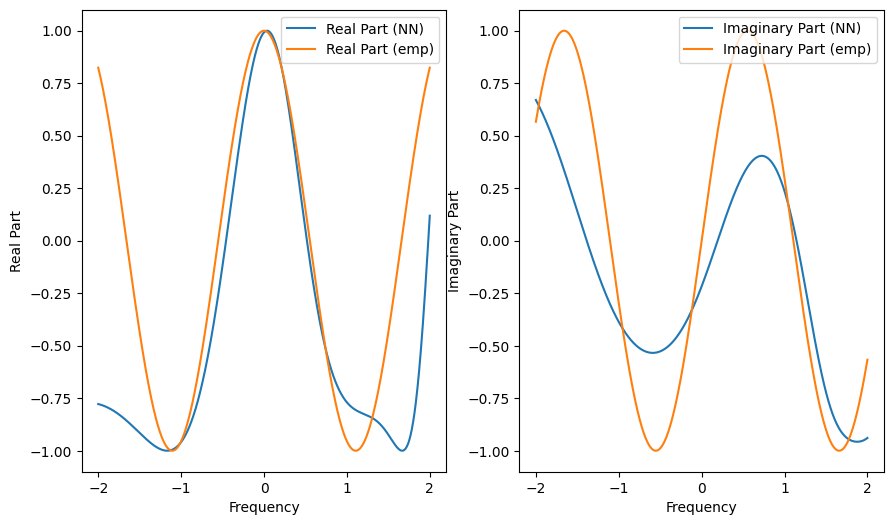

In [16]:
freq_values = torch.linspace(-2, 2, 1000).to(device)
state = (b_obs[t_index,:].repeat(1000,1)).to(device)

evalPlot = torch.cat((state,freq_values.unsqueeze(1)),dim=1).to(device)

cfNN = cf_network(evalPlot).detach()

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
# plt.plot(freq_values.cpu(), ecf_eval.real.cpu(), label='Real Part (ECF)')
plt.plot(freq_values.cpu(), cfNN.real.cpu(), label='Real Part (NN)')
plt.plot(freq_values.cpu(), torch.exp(1j*freq_values*b_returns[t_index]).real.cpu(), label='Real Part (emp)')
plt.xlabel('Frequency')
plt.ylabel('Real Part')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(freq_values.cpu(), cfNN.imag.cpu(), label='Imaginary Part (NN)')
plt.plot(freq_values.cpu(), torch.exp(1j*freq_values*b_returns[t_index]).imag.cpu(), label='Imaginary Part (emp)')
plt.xlabel('Frequency')
plt.ylabel('Imaginary Part')
plt.legend()

(array([1., 0., 1., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 2., 1.]),
 array([-3.13398838, -2.75177264, -2.36955714, -1.9873414 , -1.60512578,
        -1.22291017, -0.84069455, -0.45847887, -0.07626323,  0.3059524 ,
         0.68816805,  1.07038367,  1.45259929,  1.83481503,  2.21703053,
         2.59924626,  2.981462  ,  3.3636775 ,  3.74589324,  4.12810898,
         4.51032448]),
 <BarContainer object of 20 artists>)

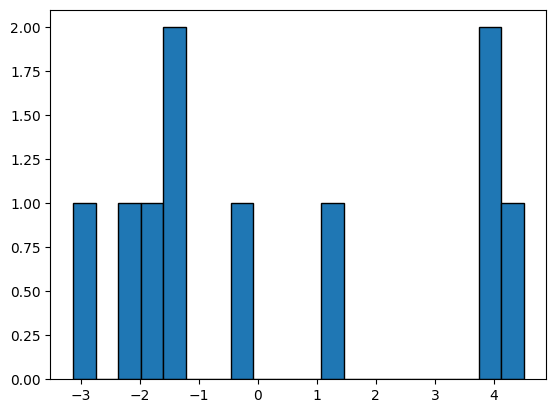

In [17]:
plt.hist(omega, bins=20, edgecolor='black')

In [18]:
env = gym.make('CartPole-v1')
st_state = b_obs[t_index,:].numpy()
num_st = 1000
r = np.zeros(num_st)
for i in range(num_st):
    _,_ = env.reset()
    episode_return = 0
    env.state = st_state
    
    state = st_state
    done = False
    truncated = False
    while not done and not truncated:
        action = agent.get_action(torch.Tensor(st_state)).numpy()
        state, reward, done, truncated, _ = env.step(action)
        episode_return += reward
    r[i] = episode_return
print(np.mean(r))

22.537


(array([138., 295., 186., 129.,  77.,  55.,  44.,  15.,  12.,  13.,  11.,
          5.,   6.,   5.,   2.,   3.,   0.,   1.,   2.,   1.]),
 array([  8. ,  12.6,  17.2,  21.8,  26.4,  31. ,  35.6,  40.2,  44.8,
         49.4,  54. ,  58.6,  63.2,  67.8,  72.4,  77. ,  81.6,  86.2,
         90.8,  95.4, 100. ]),
 <BarContainer object of 20 artists>)

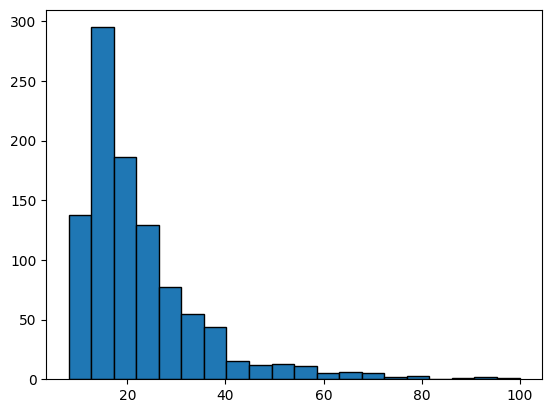

In [19]:
plt.hist(r, bins=20, edgecolor='black')

In [20]:
def ecf(samples,omega):
    expo_samples = torch.exp(1j*omega*samples)  

    return torch.mean(expo_samples, dim=0)

vectorized_ecf = torch.vmap(ecf,in_dims=(None,0),chunk_size=100)
freq_values = torch.linspace(-2, 2, 1000)
ecfSamp = vectorized_ecf(torch.Tensor(r)*0.25, freq_values)

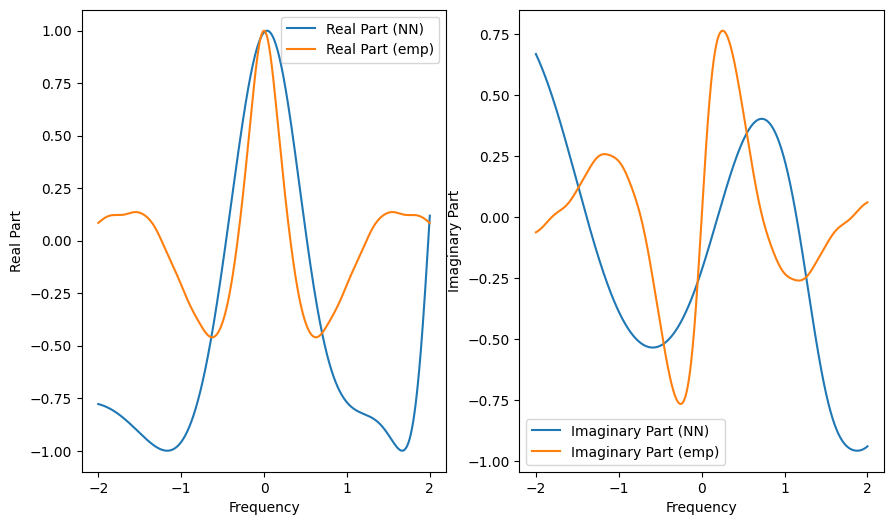

In [21]:
state = (b_obs[t_index,:].repeat(1000,1))
evalPlot = torch.cat((state,freq_values.unsqueeze(1)),dim=1)
cfNN = cf_network(evalPlot).detach()

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
# plt.plot(freq_values.cpu(), ecf_eval.real.cpu(), label='Real Part (ECF)')
plt.plot(freq_values, cfNN.real.cpu(), label='Real Part (NN)')
plt.plot(freq_values, ecfSamp.real, label='Real Part (emp)')
plt.xlabel('Frequency')
plt.ylabel('Real Part')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(freq_values.cpu(), cfNN.imag.cpu(), label='Imaginary Part (NN)')
plt.plot(freq_values.cpu(), ecfSamp.imag, label='Imaginary Part (emp)')
plt.xlabel('Frequency')
plt.ylabel('Imaginary Part')
plt.legend()

In [22]:
cf_network.load_state_dict(model_copies[3])

<All keys matched successfully>

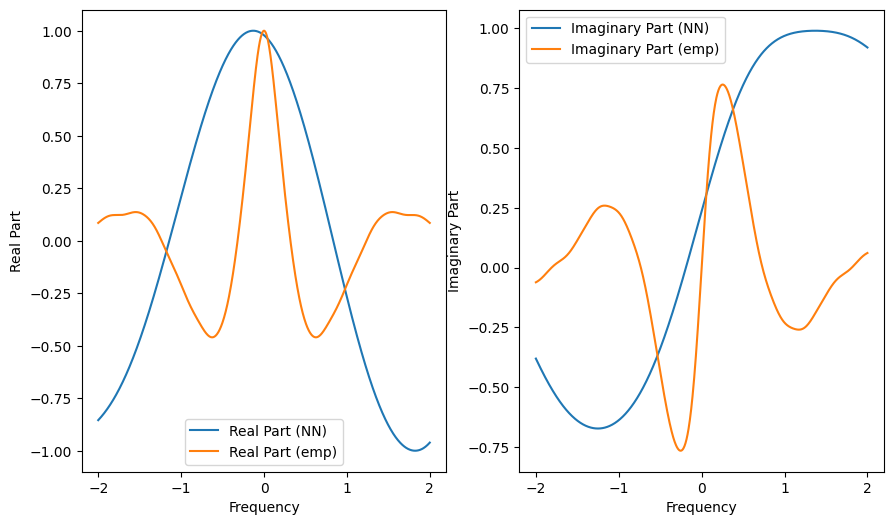

In [23]:
state = (b_obs[t_index,:].repeat(1000,1))
evalPlot = torch.cat((state,freq_values.unsqueeze(1)),dim=1)
cfNN = cf_network(evalPlot).detach()

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
# plt.plot(freq_values.cpu(), ecf_eval.real.cpu(), label='Real Part (ECF)')
plt.plot(freq_values, cfNN.real.cpu(), label='Real Part (NN)')
plt.plot(freq_values, ecfSamp.real, label='Real Part (emp)')
plt.xlabel('Frequency')
plt.ylabel('Real Part')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(freq_values.cpu(), cfNN.imag.cpu(), label='Imaginary Part (NN)')
plt.plot(freq_values.cpu(), ecfSamp.imag, label='Imaginary Part (emp)')
plt.xlabel('Frequency')
plt.ylabel('Imaginary Part')
plt.legend()